In [1]:
import folium
from folium import plugins
from folium.plugins import MarkerCluster
import psycopg2
import csv
import pandas as pd
import json
from area import area

from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT 


In [2]:
# Use this data set for your final submission of your Assignment 3
# Uncomment the following line after you unit test your code and ready to run and submit your assignment on this dataset 

db_connection = psycopg2.connect(host='129.105.248.26',dbname="chicago_crimes", user="xoy5176")


# Use the following dataset for unit testing purposes only. It takes roughly 5 minutes to omplete.
# Comment the following line when you are done with your unit testing and ready to run your assignment on the complete dataset and submit your Assignment 

db_connection = psycopg2.connect(host='129.105.248.26',dbname="chicago_crimes_ut", user="xoy5176")



cursor = db_connection.cursor()

### Chicago Crimes Dataset

The chicago crimes database on the DSCC/PostgreSQL server was created using data from the Crimes_2001_to_present.csv file that is available on Chicago data portal.

While working on this dataset, It is prudent to make a note of the following:
1. Geospatial  queries are very demanding for system resouces like CPU, GPU, Memory, and DISK
1. We are interested in the data set of the past 2 years, and when you execute Geospatial type queries, please be advised that these queries slow down your machine. 
2. There are two dataset that you will use in this assignment
    - **chicago_crimes_ut**  : Use this  mini dataset that has data for rougly a month for coding/debugging and unit testing
    - **chicago_crimes** : Use this dataset that has data for 2 years for your final submission


### Algorithm Performance

- **Sort algorithms** used by the database engines vary in performance between O($N log N$) and O($ N^{2} $) where $N$ is the size of the number

- **Search algorithms** used by the database engines vary in performance between O($log N$) and O($ N $) where $N$ is the size of the number




## What are the column names in the 2 tables that we will use from chicago_crimes database?

In [3]:
# Get the column names for table crimes

cursor.execute("SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'crimes';")

rows=cursor.fetchall()

rows

[('id',),
 ('caseno',),
 ('date_of_occurrence',),
 ('block',),
 ('iucr',),
 ('primary_type',),
 ('description',),
 ('location_description',),
 ('arrest',),
 ('domestic',),
 ('beat',),
 ('district',),
 ('ward',),
 ('community_area',),
 ('fbi_cd',),
 ('xcoordinate',),
 ('ycoordinate',),
 ('year',),
 ('updated_on',),
 ('latitude',),
 ('longitude',),
 ('location',),
 ('where_is',)]

In [4]:
# Get the column names for table police_stations

cursor.execute("SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'police_stations';")

rows=cursor.fetchall()

rows

[('district',),
 ('district_name',),
 ('address',),
 ('city',),
 ('state',),
 ('zip',),
 ('website',),
 ('phone',),
 ('fax',),
 ('tty',),
 ('x_coordinate',),
 ('y_coordinate',),
 ('latitude',),
 ('longitude',),
 ('location',),
 ('where_is',)]

## Lets get a sample of 5 rows from the crimes table in the database

In [5]:
# Get 5 rows from the table crimes

cursor.execute("SELECT * from crimes limit 5;")

rows=cursor.fetchall()

rows

[(24368,
  'JC103046',
  datetime.datetime(2019, 1, 3, 14, 37),
  '050XX S INDIANA AVE',
  '110',
  'HOMICIDE',
  'FIRST DEGREE MURDER',
  'AUTO',
  False,
  False,
  224,
  2,
  3.0,
  '38',
  '01A',
  1178455.0,
  1871575.0,
  2019,
  datetime.datetime(2019, 1, 10, 15, 16),
  41.80290852,
  -87.62104831,
  '(41.802908524, -87.62104831)',
  '0101000020E6100000368AD5B4C5E64440E92B6941BFE755C0'),
 (24369,
  'JC103046',
  datetime.datetime(2019, 1, 3, 14, 37),
  '050XX S INDIANA AVE',
  '110',
  'HOMICIDE',
  'FIRST DEGREE MURDER',
  'AUTO',
  False,
  False,
  224,
  2,
  3.0,
  '38',
  '01A',
  1178455.0,
  1871575.0,
  2019,
  datetime.datetime(2019, 1, 10, 15, 16),
  41.80290852,
  -87.62104831,
  '(41.802908524, -87.62104831)',
  '0101000020E6100000368AD5B4C5E64440E92B6941BFE755C0'),
 (24370,
  'JC105864',
  datetime.datetime(2019, 1, 5, 16, 23),
  '012XX N ADA ST',
  '110',
  'HOMICIDE',
  'FIRST DEGREE MURDER',
  'STREET',
  False,
  False,
  1433,
  14,
  2.0,
  '24',
  '01A',
  

In [6]:
cursor.execute("SELECT count(*) from crimes;")

rows=cursor.fetchall()

rows

[(14436,)]

## Lets execute  few  Queries

## Query #1:
- Calculate the total number of crimes in every district and plot that on Choropleth map

In [7]:
cursor.execute("SELECT district, count(district) from crimes GROUP BY district")
rows=cursor.fetchall()

In [8]:
crimes_per_district = pd.DataFrame(rows, columns=['dist_num','number_of_crimes'])
crimes_per_district['dist_num'] = crimes_per_district['dist_num'].astype(str)

crimes_per_district.head()

dist_num  number_of_crimes
0       24               412
1       11              1113
2        8               886
3       19               608
4       25               726

In [9]:
crimes_dataset = pd.DataFrame(rows)

In [10]:
crimes_dataset.head()

0     1
0  24   412
1  11  1113
2   8   886
3  19   608
4  25   726

In [11]:
total_number_of_crimes_per_district_map = folium.Map(location =(41.8781, -87.6298),zoom_start=11)

In [12]:
folium.Choropleth(geo_data="Boundaries.geojson", 
              fill_color='OrRd', 
              fill_opacity=0.5, 
              line_opacity=1,
              data = crimes_per_district,
              key_on='feature.properties.dist_num',
              columns = ['dist_num', 'number_of_crimes']
              ).add_to(total_number_of_crimes_per_district_map)

In [13]:
cursor.execute("""SELECT ST_X(ST_AsText(Where_IS)), ST_Y(ST_AsText(Where_IS)), district from police_stations where district!='Headquarters'""")
police_stations = cursor.fetchall()

for police_station in police_stations:
    police_station_location = (police_station[0],police_station[1])
    cursor.execute("SELECT district, count(district) from crimes where district= %s GROUP BY district",[police_station[2]])
    districts_crime_numbers = cursor.fetchall()
    for district in districts_crime_numbers:
        folium.Marker(location = police_station_location,popup=folium.Popup(html="District No : %s  has   Total Number of Crimes:%s" %district ,max_width=450)).add_to(total_number_of_crimes_per_district_map)


- **Lets plot the Choropleth map and notice  the intensity of color on the different districts**
- **The Blue POPUP represents the location of police station in the different districts in the map**

In [14]:
total_number_of_crimes_per_district_map

## Query #2:
- Calculate the total number of **violent crimes** in every district and plot that in a table on Choropleth map

Well, we really need only the violent crimes per district, so we will filter only those crimes that we are interested in. Please note that we are not interested to plot property crimes, we are really after violent crimes and in particular **Gun** related crimes.

So for now, lets plot violent crimes on Choropleth map and later on we will filter only Gun related crimes

In [15]:
violent_crime_categories='THEFT','ASSAULT','ROBBERY','KIDNAPPING','CRIM SEXUAL ASSAULT','BATTERY','MURDER'

In [16]:
cursor.execute("SELECT district, count(district) from crimes where PRIMARY_TYPE in %s GROUP BY district",[violent_crime_categories])
rows=cursor.fetchall()
violent_crime_data=pd.DataFrame(rows, columns=['district_num','number_of_violent_crimes'])
violent_crime_data['district_num'] = violent_crime_data['district_num'].astype(str)
violent_crime_data

district_num  number_of_violent_crimes
0             8                       488
1            11                       407
2            24                       216
3            19                       368
4            25                       362
5             4                       400
6            14                       309
7             3                       387
8            17                       220
9            20                       147
10           22                       217
11            9                       312
12            7                       367
13           10                       362
14            1                       624
15            5                       293
16           18                       605
17            2                       349
18           16                       252
19           15                       291
20            6                       457
21           12                       430

In [17]:
violent_crimes_per_district_map= folium.Map(location =(41.8781, -87.6298),zoom_start=11)
folium.Choropleth(geo_data="Boundaries.geojson", 
              fill_color='YlOrRd', 
              fill_opacity=0.5, 
              line_opacity=1,
              data = violent_crime_data,
              key_on='feature.properties.dist_num',
              columns = ['district_num', 'number_of_violent_crimes'],
              legend_name="VOILENT CRIME MAP"
              ).add_to(violent_crimes_per_district_map)


In [18]:
cursor.execute("""SELECT ST_X(ST_AsText(Where_IS)), ST_Y(ST_AsText(Where_IS)), district from police_stations where district!='Headquarters'""")
police_stations = cursor.fetchall()

for police_station in police_stations:
    police_station_location =(police_station[0],police_station[1])
    cursor.execute("SELECT PRIMARY_TYPE, count(PRIMARY_TYPE) from crimes where district =%s AND PRIMARY_TYPE in %s GROUP BY PRIMARY_TYPE",[police_station[2],violent_crime_categories])
    data = cursor.fetchall()
    violent_crimes_per_district_df = pd.DataFrame(data, columns=['Description', 'Number of Violent Crimes'])
    header = violent_crimes_per_district_df.to_html(classes='table table-striped table-hover table-condensed table-responsive')
    folium.Marker(location=police_station_location, popup=folium.Popup(html="District Number %s - Violent Crimes %s" %(police_station[2],header))).add_to(violent_crimes_per_district_map)



In [19]:
violent_crimes_per_district_map

## Query #3:
- Calculate the total number of **gun related violent crimes** in every district and plot that in a table on Choropleth map


Lets first create a dataframe of gun crimes per district first to get an idea about the number of gun crimes per district


In [20]:

gun='%GUN%'
cursor.execute("SELECT district, count(district) from crimes where DESCRIPTION::text LIKE %s GROUP BY district",[gun])
districts_gun_violent_crimes = cursor.fetchall()
districts_gun_violent_crimes_df = pd.DataFrame(districts_gun_violent_crimes, columns=['dist_num','gun_crimes'])
districts_gun_violent_crimes_df['dist_num'] = districts_gun_violent_crimes_df['dist_num'].astype(str)
districts_gun_violent_crimes_df

dist_num  gun_crimes
0        24           9
1         8          49
2        11          69
3        19          11
4        25          43
5         4          50
6        14          12
7         3          57
8        17           7
9        20           5
10       22          24
11       10          58
12        9          39
13        7          67
14        1           6
15        5          44
16       18          14
17        2          34
18       16          12
19       15          34
20        6          63
21       12          38

In [21]:
districts_gun_violent_crimes_map = folium.Map(location =(41.8781, -87.6298),zoom_start=11)
folium.Choropleth(geo_data="Boundaries.geojson", 
              fill_color='YlOrRd', 
              fill_opacity=0.5, 
              line_opacity=1,
              data = districts_gun_violent_crimes_df,
              key_on='feature.properties.dist_num',
              columns = ['dist_num', 'gun_crimes'],
              legend_name="GUN CRIME"
              ).add_to(districts_gun_violent_crimes_map)


Now, lets create a dataframe of the **different types of gun crimes for every district** and then plot it on Choropleth map

In [22]:

cursor.execute("""SELECT ST_X(ST_AsText(Where_IS)), ST_Y(ST_AsText(Where_IS)), district from police_stations where district!='Headquarters'""")

gun='%GUN%'
police_stations = cursor.fetchall()

for police_station in police_stations:
    police_station_location = (police_station[0],police_station[1])
    cursor.execute("""SELECT DESCRIPTION, count(DESCRIPTION) from crimes where district=%s and DESCRIPTION::text LIKE %s GROUP BY DESCRIPTION""",[police_station[2],gun])
    district_gun_violent_crimes=cursor.fetchall()
    district_gun_violent_crimes_df=pd.DataFrame(district_gun_violent_crimes, columns=['Description', 'Number of Gun Crime'])
    header = district_gun_violent_crimes_df.to_html(classes='table table-striped table-hover table-condensed table-responsive')
    folium.Marker(location=police_station_location,popup=folium.Popup(html="District No: %s GUN_Crime: %s" %(police_station[2],header) )).add_to(districts_gun_violent_crimes_map)
    


In [23]:
districts_gun_violent_crimes_map

## Query #4:
- Calculate the crime density per district

In [24]:
district=[]
tarea=[]

with open('Boundaries.geojson') as f:
    data = json.load(f)
    a = data['features']
    for i in range(len(a)):
        obj=a[i]['geometry']
        n= a[i]['properties']
        district.append(n['dist_num'])
        tarea.append(area(obj)/10000)

af=pd.DataFrame({'dist_num': district,'district_area_inHectares':tarea})
af['dist_num'] = af['dist_num'].astype(str)
final_data= pd.merge(af, crimes_per_district, on='dist_num', how='inner')
final_data['crime_density'] = round(final_data['number_of_crimes']/(final_data['district_area_inHectares']/100))
final_data

dist_num  district_area_inHectares  number_of_crimes  crime_density
0        17               2492.727155               386           15.0
1        20               1132.170216               254           22.0
2        19               2225.035732               608           27.0
3        25               2827.989237               726           26.0
4        14               1555.869965               508           33.0
5         7               1688.670732               745           44.0
6         3               1576.063931               695           44.0
7         4               7068.152865               790           11.0
8         6               2099.682124               844           40.0
9        22               3490.416073               442           13.0
10        5               3318.613379               635           19.0
11       24               1406.081387               412           29.0
12       16               8171.776367               473            6.0
13        8               5992.169760               886           15.0
14       18               1215.520046               869           71.0
15       12               2509.453028               700           28.0
16       11               1582.727274              1113           70.0
17       15                989.631393               530           54.0
18       10               2038.988883               779           38.0
19        1               1214.818895               854           70.0
20        9               3505.216898               585           17.0
21        2               1949.690970               602           31.0

## Query #5:
- Create **Marker Clusters** on Choropleth map for those **gun related violent crimes** that resulted in **arrest (green icon)** and those that **didn't (red icon)**

In [25]:
gun_crime_arrests_map = folium.Map(location =(41.8781, -87.6298),zoom_start=11)
folium.Choropleth(geo_data="Boundaries.geojson", 
              fill_color='YlOrRd', 
              fill_opacity=0.5, 
              line_opacity=1,
              data = districts_gun_violent_crimes_df,
              key_on='feature.properties.dist_num',
              columns = ['dist_num', 'gun_crimes'],
              legend_name="GUN CRIME"
              ).add_to(gun_crime_arrests_map)


In [26]:
cursor.execute("""SELECT ST_X(ST_AsText(Where_IS)), ST_Y(ST_AsText(Where_IS)), district from police_stations where district!='Headquarters'""")
gun='%GUN%'

police_stations = cursor.fetchall()

marker_cluster = MarkerCluster().add_to(gun_crime_arrests_map)

for police_station in police_stations:
    police_station_location = (police_station[0],police_station[1])
    cursor.execute("""SELECT DISTINCT ON(caseno) caseno, block,DESCRIPTION, count(arrest), arrest,latitude, longitude from crimes where district=%s and DESCRIPTION::text LIKE %s GROUP BY caseno,block, DESCRIPTION,arrest, latitude, longitude""",[police_station[2],gun])
    crimes_per_district = cursor.fetchall()
    for crime in crimes_per_district:
        if crime[4]==True:
            folium.Marker(location=(crime[5],crime[6]),popup=folium.Popup(html="District No: %s <br> Description: %s <br> Block: %s" %(police_station[2],crime[2],crime[1])),icon=folium.Icon(color='green', icon='ok-sign'),).add_to(marker_cluster)
        else:
            folium.Marker(location=(crime[5],crime[6]),popup=folium.Popup(html="District No: %s <br> Description: %s<br> Block: %s" %(police_station[2],crime[2],crime[1])),icon=folium.Icon(color='red', icon='remove-sign'),).add_to(marker_cluster)

            


In [27]:
crimes_per_district[:3]

[('JC100027',
  '017XX N MAYFIELD AVE',
  'UNLAWFUL POSS OF HANDGUN',
  1,
  True,
  41.91205157,
  -87.7728073),
 ('JC100191',
  '017XX N NEWCASTLE AVE',
  'UNLAWFUL POSS OF HANDGUN',
  1,
  True,
  41.91174566,
  -87.7960732),
 ('JC103615',
  '019XX N LA CROSSE AVE',
  'ARMED: HANDGUN',
  1,
  False,
  41.91638097,
  -87.74732207)]

In [28]:
gun_crime_arrests_map

## Query #6:
- Plot on Choropleth map the **farthest Block** that has a gun crime from every police station in every district 

In [29]:
farthest_block_gun_crime_map = folium.Map(location =(41.8781, -87.6298),zoom_start=11)
folium.Choropleth(geo_data="Boundaries.geojson", 
              fill_color='YlOrRd', 
              fill_opacity=0.5, 
              line_opacity=1,
              data = districts_gun_violent_crimes_df,
              key_on='feature.properties.dist_num',
              columns = ['dist_num', 'gun_crimes'],
              legend_name="GUN CRIME"
              ).add_to(farthest_block_gun_crime_map)


In [30]:


cursor.execute("""SELECT ST_X(ST_AsText(Where_IS)), ST_Y(ST_AsText(Where_IS)), district from police_stations where district!='Headquarters'""")
police_stations = cursor.fetchall()

gun='%GUN%'

for police_station in police_stations:
    
    cursor.execute("""
                        WITH crime_distance_from_police_station AS (
                                        SELECT  A.where_is as crime_where_is, 
                                                B.where_is as police_where_is,
                                                A.district as crime_district,
                                                A.block as crime_block,
                                                ST_Distance(A.where_is,B.where_is) as distance 
                                        FROM crimes as A, police_stations as B 
                                        WHERE A.district=%s and DESCRIPTION::text LIKE %s and B.district= %s 
                        )
    
                        SELECT DISTINCT on (crime_distance_from_police_station.crime_block) 
                                        crime_distance_from_police_station.crime_district,
                                        crime_distance_from_police_station.crime_block, 
                                        crime_distance_from_police_station.crime_where_is,
                                        crime_distance_from_police_station.distance 
                        FROM crime_distance_from_police_station 
                        WHERE distance = (SELECT max(distance) 
                                        FROM crime_distance_from_police_station )""",[police_station[2],gun,police_station[2]])
    
    farthest_block_gun_crime = cursor.fetchall()

    cursor.execute("SELECT ST_X(ST_AsText(%s)), ST_Y(ST_AsText(%s))",(farthest_block_gun_crime[0][2],farthest_block_gun_crime[0][2]))
    farthest_block_gun_crime_location = cursor.fetchall()
    folium.Marker(location=(police_station[0],police_station[1]),popup=folium.Popup(html="Police Station <br> District No.:%s <br> Farthest Gun_Crime Block:%s"%(farthest_block_gun_crime[0][0],farthest_block_gun_crime[0][1]))).add_to(farthest_block_gun_crime_map)
    folium.CircleMarker(farthest_block_gun_crime_location[0],radius=5,color='#ff3187',popup=folium.Popup(html="District No.:%s <br> Block:%s"%(farthest_block_gun_crime[0][0],farthest_block_gun_crime[0][1]))).add_to(farthest_block_gun_crime_map) 




In [31]:
farthest_block_gun_crime_map

<br>
<div class="alert alert-warning">
    
# Requirements



**The PDF document your are submitting must have the source code and the output for the following  requirements**


</div>
<br>


### Requirement #1: 
- Calculate the gun crimes density in every district

In [32]:
db_connection = psycopg2.connect(host='129.105.248.26',dbname="chicago_crimes_ut", user="xoy5176")
cursor = db_connection.cursor()

cursor.execute("""
SELECT 
  police_stations.district_name, 
  CAST(COUNT(crimes.id) AS NUMERIC) / CAST(police_stations.district AS NUMERIC) AS gun_crime_density 
FROM 
  crimes 
  JOIN police_stations ON CAST(crimes.district AS TEXT) = police_stations.district 
WHERE 
  crimes.primary_type = 'WEAPONS VIOLATION' 
GROUP BY 
  police_stations.district_name, police_stations.district;
""")

rows=cursor.fetchall()

rows

[('Jefferson Park', Decimal('0.37500000000000000000')),
 ('Ogden', Decimal('2.9000000000000000')),
 ('Harrison', Decimal('3.5454545454545455')),
 ('Deering', Decimal('1.8888888888888889')),
 ('Calumet', Decimal('6.8000000000000000')),
 ('South Chicago', Decimal('9.2500000000000000')),
 ('Central', Decimal('2.0000000000000000')),
 ('Gresham', Decimal('6.3333333333333333')),
 ('Chicago Lawn', Decimal('2.2500000000000000')),
 ('Albany Park', Decimal('0.29411764705882352941')),
 ('Grand Crossing', Decimal('6.6666666666666667')),
 ('Shakespeare', Decimal('0.42857142857142857143')),
 ('Lincoln', Decimal('0.15000000000000000000')),
 ('Austin', Decimal('0.66666666666666666667')),
 ('Englewood', Decimal('5.8571428571428571')),
 ('Town Hall', Decimal('0.26315789473684210526')),
 ('Near North', Decimal('0.16666666666666666667')),
 ('Wentworth', Decimal('6.0000000000000000')),
 ('Grand Central', Decimal('1.0800000000000000')),
 ('Morgan Park', Decimal('0.27272727272727272727')),
 ('Near West', Dec

### Requirement #2: 
- Locate the **farthest** UNLAWFUL POSS OF HANDGUN crime from the police station in every district. The popup on Choropleth map shall display the district number and the block

In [33]:
db_connection = psycopg2.connect(host='129.105.248.26',dbname="chicago_crimes_ut", user="xoy5176")
cursor = db_connection.cursor()
cursor.execute('''SELECT
  police_stations.district_name,
  ST_X(police_stations.location) AS police_stations_longitude,
  ST_Y(police_stations.location) AS police_stations_latitude,
  crimes.block
FROM
  crimes
  JOIN (
    SELECT
      district,
      district_name,
      location
    FROM
      police_stations
  ) AS police_stations ON CAST(crimes.district AS TEXT) = police_stations.district
WHERE
  crimes.primary_type = 'UNLAWFUL POSS OF HANDGUN'
  AND crimes.location IS NOT NULL''')


rows = cursor.fetchall()


chicago_map = folium.Map(location=[41.881832, -87.623177], zoom_start=11)


for row in rows:
    district = row[0]
    longitude = row[1]
    latitude = row[2]
    block = row[3]
    popup = f"District: {district}<br>Block: {block}"
    folium.Marker(location=[latitude, longitude], popup=popup, icon=folium.Icon(color='red')).add_to(chicago_map)

# Display the map
chicago_map





### Requirement #3: 

- Create **Marker Clusters** on Choropleth map for those **gun related violent crimes** that have Location Desciption as RESIDENCE in ** (green icon)** and those that have Location Desciption as STREET in **(red icon)**

In [34]:
import folium
from folium.plugins import MarkerCluster
import psycopg2

db_connection = psycopg2.connect(host='129.105.248.26', dbname='chicago_crimes_ut', user='xoy5176')
chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=10)


cursor_residence = db_connection.cursor()
cursor_residence.execute("""
    SELECT 
        crimes.latitude, 
        crimes.longitude, 
        location_description 
    FROM 
        crimes 
    WHERE 
        crimes.primary_type = 'HOMICIDE' 
        AND location_description = 'RESIDENCE';
""")


residence_cluster = MarkerCluster(name='Residence Crimes', control=True)
for row in cursor_residence:
    popup_text = f"Location Description: {row[2]}"
    marker = folium.Marker(location=[row[0], row[1]], popup=popup_text, icon=folium.Icon(color='green', icon='home'))
    marker.add_to(residence_cluster)


cursor_street = db_connection.cursor()
cursor_street.execute("""
    SELECT 
        crimes.latitude, 
        crimes.longitude, 
        location 
    FROM 
        crimes 
    WHERE 
        crimes.primary_type = 'HOMICIDE' 
        AND location_description = 'STREET';
""")


street_cluster = MarkerCluster(name='Street Crimes', control=True)
for row in cursor_street:
    popup_text = f"Location Description: {row[2]}"
    marker = folium.Marker(location=[row[0], row[1]], popup=popup_text, icon=folium.Icon(color='red', icon='info-sign'))
    marker.add_to(street_cluster)


residence_cluster.add_to(chicago_map)
street_cluster.add_to(chicago_map)
folium.LayerControl().add_to(chicago_map)
chicago_map


### Requirement #4: 
- Locate the **Block** that has the **higest number of gun crimes**. The popup on Choropleth map shall display the Block in every district along with the total number of gun crimes for that block

In [35]:
import folium
import psycopg2


db_connection = psycopg2.connect(host='129.105.248.26', dbname='chicago_crimes_ut', user='xoy5176')
chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=10)


query1 = """
    SELECT 
        block, 
        COUNT(*) AS num_gun_crimes 
    FROM 
        crimes 
    WHERE 
        primary_type IN ('WEAPONS VIOLATION', 'HOMICIDE', 'ROBBERY')
    GROUP BY 
        block 
    ORDER BY 
        num_gun_crimes DESC 
    LIMIT 1
"""


cursor = db_connection.cursor()
cursor.execute(query1)
result = cursor.fetchone()
block_with_most_gun_crimes = result[0]
total_gun_crimes_for_block = result[1]


query2 = f"""
    SELECT 
        district, 
        district_name 
    FROM 
        police_stations 
    WHERE 
        ST_Contains(
            (SELECT 
                ST_Transform(
                    ST_SetSRID(
                        ST_MakeBox2D(
                            ST_Point(min(longitude), min(latitude)),
                            ST_Point(max(longitude), max(latitude))
                        ),
                        4326
                    ),
                    3857
                )
            FROM 
                crimes 
            WHERE 
                block='{block_with_most_gun_crimes}'
            ),
            ST_Transform(
                ST_SetSRID(
                    ST_MakePoint(longitude, latitude),
                    4326
                ),
                3857
            )
        );
"""


cursor.execute(query2)
results = cursor.fetchall()

for result in results:
    district = result[0]
    district_name = result[1]
    popup_text = f'Block: {block_with_most_gun_crimes}<br>Total Gun Crimes: {total_gun_crimes_for_block}'
    marker = folium.Marker(location=[police_stations_lat_lng[district_name][0], police_stations_lat_lng[district_name][1]], popup=popup_text)
    marker.add_to(chicago_map)


print(results)
chicago_map


[]


### Requirement #5: 
- Create the **Trend-Chart** for every crime type (use the complete dataset).
    - Index the crimes/dataframe based on the crime date_of_occurrence
    - Pivot data based on the primary_type
    - Use **https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html** for the moving window (365 days for the year)

/var/folders/mr/j15l_l8x2jgd3dvd9tnt8hcw0000gs/T/ipykernel_61929/1253468785.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  crimes_df = pd.read_sql(query, db_connection)


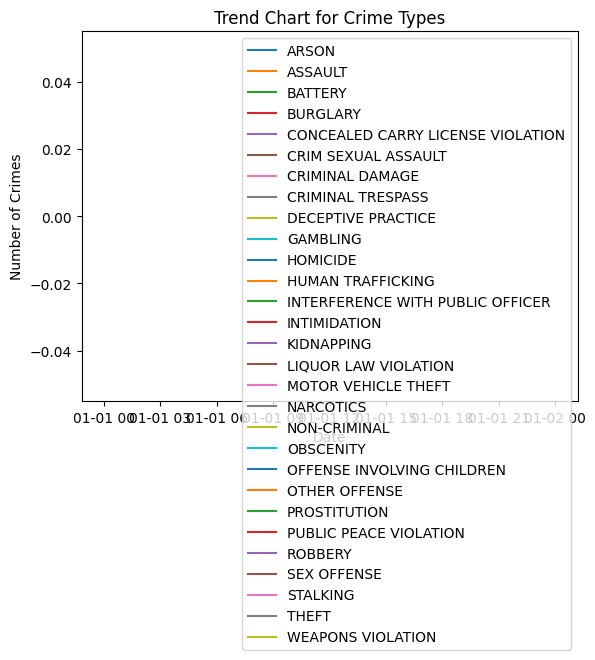

array(['HOMICIDE', 'CRIMINAL DAMAGE', 'BATTERY', 'WEAPONS VIOLATION',
       'PUBLIC PEACE VIOLATION', 'ASSAULT', 'ROBBERY', 'NARCOTICS',
       'THEFT', 'DECEPTIVE PRACTICE', 'MOTOR VEHICLE THEFT',
       'LIQUOR LAW VIOLATION', 'BURGLARY', 'CRIMINAL TRESPASS',
       'OTHER OFFENSE', 'OFFENSE INVOLVING CHILDREN',
       'INTERFERENCE WITH PUBLIC OFFICER', 'KIDNAPPING',
       'CRIM SEXUAL ASSAULT', 'SEX OFFENSE', 'ARSON',
       'CONCEALED CARRY LICENSE VIOLATION', 'INTIMIDATION',
       'PROSTITUTION', 'STALKING', 'GAMBLING', 'OBSCENITY',
       'HUMAN TRAFFICKING', 'NON-CRIMINAL'], dtype=object)

In [36]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt


db_connection = psycopg2.connect(host='129.105.248.26', dbname='chicago_crimes_ut', user='xoy5176')
query = """
    SELECT 
        date_of_occurrence,
        primary_type
    FROM 
        crimes
"""
crimes_df = pd.read_sql(query, db_connection)


pivoted_df = crimes_df.pivot_table(index='date_of_occurrence', columns='primary_type', aggfunc='size')
rolling_df = pivoted_df.rolling(window=365).mean()


for column in rolling_df.columns:
    plt.plot(rolling_df.index, rolling_df[column], label=column)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.title('Trend Chart for Crime Types')
plt.show()

# self-check
crimes_df["primary_type"].unique()


### Requirement #6: 
- What is the day of the week that has the smallest number of crimes reported?
- What is the day of the week that has the highest number of crimes reported?

In [37]:
import datetime
import psycopg2

db_connection = psycopg2.connect(host='129.105.248.26', dbname='chicago_crimes_ut', user='xoy5176')
cursor = db_connection.cursor()


query1 = """
SELECT EXTRACT(DOW FROM date_of_occurrence) as day_of_week, COUNT(*) as num_crimes
FROM crimes
GROUP BY day_of_week
ORDER BY num_crimes ASC
LIMIT 1;
"""

cursor.execute(query1)
rows = cursor.fetchall()

print("Day of the week with the smallest number of crimes reported:")
print(datetime.date(2023, 5, 1).strftime('%A'), "(", rows[0][1], "crimes)")


query2 = """
SELECT EXTRACT(DOW FROM date_of_occurrence) as day_of_week, COUNT(*) as num_crimes
FROM crimes
GROUP BY day_of_week
ORDER BY num_crimes DESC
LIMIT 1;
"""

cursor.execute(query2)
rows = cursor.fetchall()

print("Day of the week with the highest number of crimes reported:")
print(datetime.date(2023, 5, 1).strftime('%A'), "(", rows[0][1], "crimes)")


Day of the week with the smallest number of crimes reported:
Monday ( 1627 crimes)
Day of the week with the highest number of crimes reported:
Monday ( 2600 crimes)
